In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import torch

import sys
sys.path.insert(0, '../fem')
from hc2d import *
from randompolynomials import *
from GRF import *
from datasaver import *

sys.path.insert(0, '../ml')
from modelloader import loadmodelfromlabel
from VarMiON import VarMiON
from NGO import NGO
from customlosses import L2_scaled

In [2]:
%load_ext autoreload
%autoreload 2

In [57]:
simparams = {'d': 2,
             'nelems': 32,
             'etype': 'square',
             'btype': 'spline',
             'basisdegree': 1,
             'intdegree': 2,
             'nfemsamples': 2}

p_theta = {'l_min': 0.4,
           'l_max': 0.4,
           'lowerbound': 0.5,
           'upperbound': 0.99}

p_f = {'l_min': 0.2,
       'l_max': 0.2,
       'lowerbound': 0.02,
       'upperbound': 0.99}

p_eta = {'l_min': 0.3,
         'l_max': 0.3,
         'lowerbound': -1,
         'upperbound': 1}

inputdataparams = {'theta': p_theta,
          'f': p_f,
          'eta': p_eta}

trainingdataparams = {'N_samples': 10}

params = {}
params['simparams'] = simparams
params['inputdataparams'] = inputdataparams
params['trainingdataparams'] = trainingdataparams

thetaset = GRFset(**simparams, **trainingdataparams, **inputdataparams['theta'])
fset = GRFset(**simparams, **trainingdataparams, **inputdataparams['f'])
etabset = GRFset(**simparams, **trainingdataparams, **inputdataparams['eta'])
etatset = GRFset(**simparams, **trainingdataparams, **inputdataparams['eta'])
gl = 0
gr = 0

In [4]:
u_array = []

for i in range(trainingdataparams['N_samples']):
    
    print(i)
    
    inputs = {'theta': thetaset.grfs_nutils[i],
              'f': fset.grfs_nutils[i],
              'etab': etabset.grfs_nutils[i],
              'etat': etatset.grfs_nutils[i],
              'gl': 0,
              'gr': 0}

    x, u = main(**simparams, **trainingdataparams, **inputs)
    
    u_array.append(u)

0
optimize > constrained 66/1089 dofs
optimize > optimum value 0.00e+00
solve > solving 1023 dof system to machine precision using arnoldi solver
solve > solver returned with residual 5e-16
1
optimize > constrained 66/1089 dofs
optimize > optimum value 0.00e+00
solve > solving 1023 dof system to machine precision using arnoldi solver
solve > solver returned with residual 4e-16
2
optimize > constrained 66/1089 dofs
optimize > optimum value 0.00e+00
solve > solving 1023 dof system to machine precision using arnoldi solver
solve > solver returned with residual 9e-16
3
optimize > constrained 66/1089 dofs
optimize > optimum value 0.00e+00
solve > solving 1023 dof system to machine precision using arnoldi solver
solve > solver returned with residual 1e-15
4
optimize > constrained 66/1089 dofs
optimize > optimum value 0.00e+00
solve > solving 1023 dof system to machine precision using arnoldi solver
solve > solver returned with residual 3e-16
5
optimize > constrained 66/1089 dofs
optimize > o

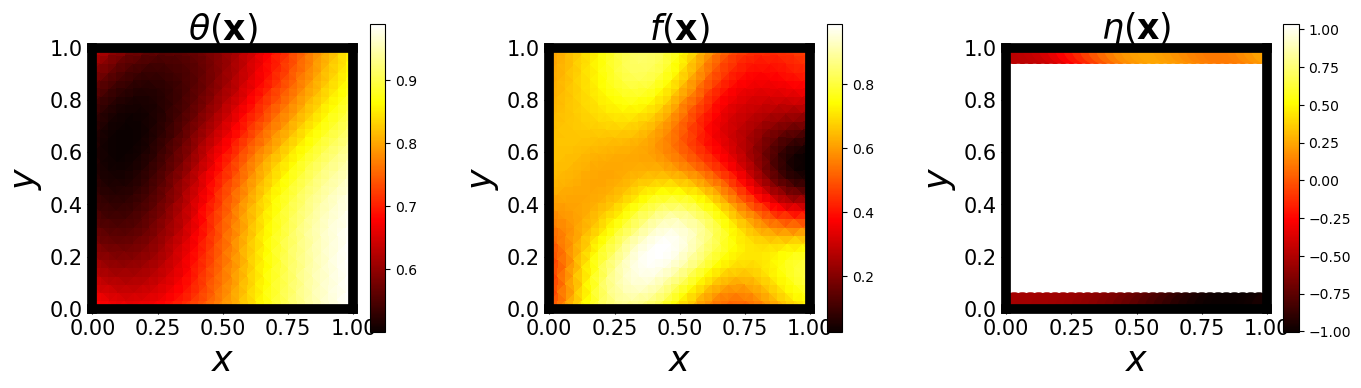

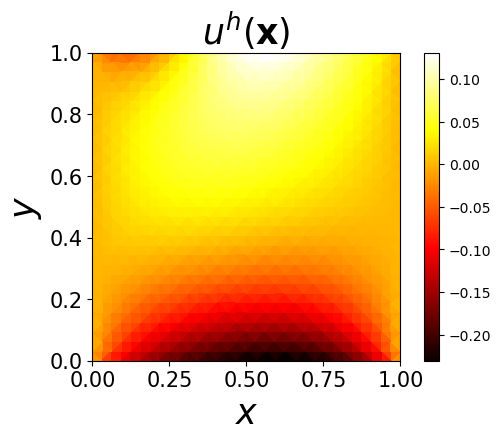

In [5]:
i=0

#plot
fig, axs = plt.subplots(1,3, figsize=(16, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.2)
size_title = 25
size_ticklabels = 15
size_axeslabels = 25
box_lw = 7

ax = axs[0]
plot0 = ax.tripcolor(x[:,0], x[:,1], thetaset.grfs_ngo[i](x), cmap='hot')
ax.set_title(r"$\theta(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.setp(ax.spines.values(), lw=box_lw, color='black', alpha=1);
fig.colorbar(plot0, ax=ax)

ax = axs[1]
plot1 = ax.tripcolor(x[:,0], x[:,1], fset.grfs_ngo[i](x), cmap='hot')
ax.set_title(r"$f(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.setp(ax.spines.values(), lw=box_lw, color='black', alpha=1);
fig.colorbar(plot1, ax=ax)

ax = axs[2]

# ax.plot(x[x[:,1]==0,0], etabset.grfs_ngo[i](x)[x[:,1]==0], label=r'$\eta_\mathrm{bottom}(x)$', linewidth=3)
# ax.plot(x[x[:,1]==1,0], etatset.grfs_ngo[i](x)[x[:,1]==1], label=r'$\eta_\mathrm{top}(x)$', linewidth=3)
# ax.set_title(r"$\eta(\mathbf{x})$", fontsize=size_title)
# ax.tick_params(axis='both', labelsize=size_ticklabels)
# ax.ticklabel_format(style='sci', scilimits=[-3,3])
# ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
# ax.set_ylabel(r'$\eta(x)$', fontsize=size_axeslabels)
# # ax.set_xlim(0,1)
# ax.legend(fontsize=16)
# # ax.set_box_aspect(1)
# ax.grid()

ax.set_title(r"$\eta(\mathbf{x})$", fontsize=size_title)
vmin = min(np.amin(etabset.grfs_ngo[i](x)),np.amin(etatset.grfs_ngo[i](x)))
vmax = max(np.amax(etabset.grfs_ngo[i](x)),np.amax(etatset.grfs_ngo[i](x)))
fig = ax.scatter(x[x[:,1]==0,0], x[x[:,1]==0,1], c=etabset.grfs_ngo[i](x)[x[:,1]==0], label=r'$\eta_\mathrm{bottom}(x)$', s=500, cmap='hot', vmin=vmin, vmax=vmax)
fig = ax.scatter(x[x[:,1]==1,0], x[x[:,1]==1,1], c=etatset.grfs_ngo[i](x)[x[:,1]==1], label=r'$\eta_\mathrm{top}(x)$', s=500, cmap='hot', vmin=vmin, vmax=vmax)
# ax.set_title(r"$\eta(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
# ax.legend(fontsize=20)
ax.set_box_aspect(1)
plt.setp(ax.spines.values(), lw=box_lw, color='black', alpha=1);
plt.colorbar(fig)
# ax.grid()

# plt.savefig("hc2d_theta_f_eta.svg", bbox_inches='tight', transparent=True)

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

fig = ax.tripcolor(x[:,0], x[:,1], u_array[i], cmap='hot')
ax.set_title(r"$u^h(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)

# plt.savefig("hc2d_u.pdf", bbox_inches='tight')

In [6]:
from VarMiON import VarMiON
from RegularNN import RegularNN
from NGO import NGO

logdir = '../../../nnlogs'

sublogdir = 'NGO_VarMiON_DeepONet'
map_location = 'cpu'
model = loadmodelfromlabel(model=NGO, label='NGO_GL', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
# sublogdir = 'DeepONet'
# map_location = 'cpu'
# model = loadmodelfromlabel(model=NGO, label='DeepONet', logdir=logdir, sublogdir=sublogdir, map_location=map_location)

RuntimeError: Error(s) in loading state_dict for NGO:
	Unexpected key(s) in state_dict: "NLBranch.layers.1.weight", "NLBranch.layers.3.weight", "NLBranch.layers.3.bias", "NLBranch.layers.3.running_mean", "NLBranch.layers.3.running_var", "NLBranch.layers.3.num_batches_tracked", "NLBranch.layers.4.weight", "NLBranch.layers.6.weight", "NLBranch.layers.6.bias", "NLBranch.layers.6.running_mean", "NLBranch.layers.6.running_var", "NLBranch.layers.6.num_batches_tracked", "NLBranch.layers.7.weight", "NLBranch.layers.9.weight", "NLBranch.layers.11.weight", "NLBranch.layers.11.bias", "NLBranch.layers.14.weight", "NLBranch.layers.16.weight", "NLBranch.layers.16.bias", "NLBranch.layers.16.running_mean", "NLBranch.layers.16.running_var", "NLBranch.layers.16.num_batches_tracked", "NLBranch.layers.17.weight", "NLBranch.layers.19.weight", "NLBranch.layers.19.bias", "NLBranch.layers.19.running_mean", "NLBranch.layers.19.running_var", "NLBranch.layers.19.num_batches_tracked", "NLBranch.layers.20.weight", "NLBranch.layers.22.weight". 

In [7]:
i=2
theta = thetaset.grfs_ngo[i]
f = fset.grfs_ngo[i]
etab = etabset.grfs_ngo[i]
etat = etatset.grfs_ngo[i]

# model.hparams['Q'] = 100
# u_hat = model.simforward_FEM(theta, f, etab, etat, x)
u_hat = model.simforward(theta, f, etab, etat, x)
# mus = model.mus[0].detach().numpy()
# sigmas = torch.exp(model.log_sigmas[0]).detach().numpy()

#plot
fig, axs = plt.subplots(1,3, figsize=(16, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.2)
size_title = 25
size_ticklabels = 12
size_axeslabels = 25
box_lw = 7

ax = axs[0]
fig = ax.tripcolor(x[:,0], x[:,1], u_array[i], cmap='hot')
ax.set_title(r"$u(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.setp(ax.spines.values(), lw=box_lw, color='black', alpha=1);
plt.colorbar(fig)

ax = axs[1]
fig = ax.tripcolor(x[:,0], x[:,1], u_hat, cmap='hot', vmin=np.amin(u_array[i]), vmax=np.amax(u_array[i]))
# for i in range(72):
#     ax.scatter(mus[i,0], mus[i,1], s=50, alpha=0.5, color='blue')
#     ax.scatter(mus[i,0], mus[i,1], s=10000*sigmas[i], alpha=0.1, color='C0')
ax.set_title(r"$\hat{u}(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.setp(ax.spines.values(), lw=box_lw, color='black', alpha=1);
plt.colorbar(fig)

ax = axs[2]
fig = ax.tripcolor(x[:,0], x[:,1], np.sqrt((u_hat - u_array[i])**2)/np.average(np.sqrt(u_array[i]**2)))#, norm=matplotlib.colors.LogNorm())
ax.set_title(r"$||\hat{u} - {u}||_{2}/||u||_{2}$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.setp(ax.spines.values(), lw=box_lw, color='black', alpha=1);
plt.colorbar(fig)

# plt.savefig("NGOprediction.svg", bbox_inches='tight', transparent=True)

L2 = np.average(np.sqrt((u_hat - u_array[i])**2))
L2_sc = L2/np.average(np.sqrt(u_array[i]**2))
print(L2_sc)
# APE = np.abs((u_hat - u)/u)
# APE[APE==np.inf] = np.nan
# MAPE = np.nanmean(APE)
# print('MAPE: '+(str(MAPE)))
# # plt.savefig("nonzeroN.pdf", bbox_inches='tight')

NameError: name 'model' is not defined

NameError: name 'u_hat' is not defined

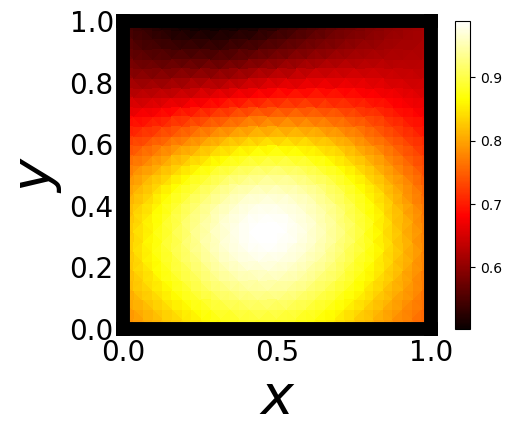

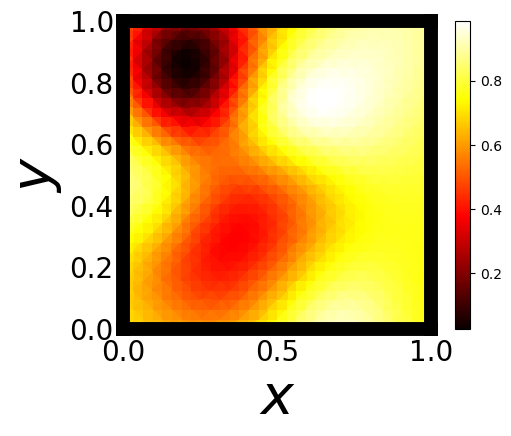

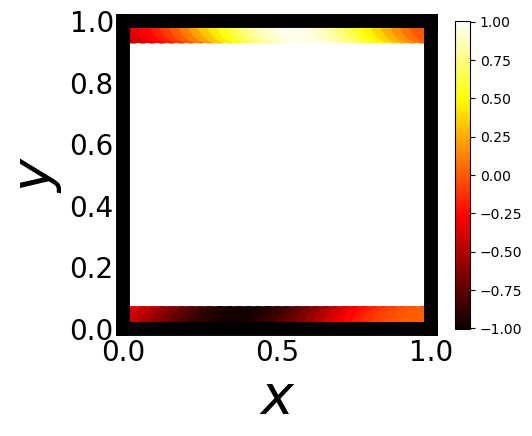

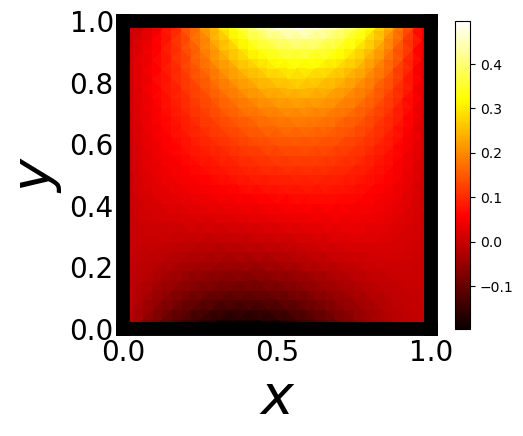

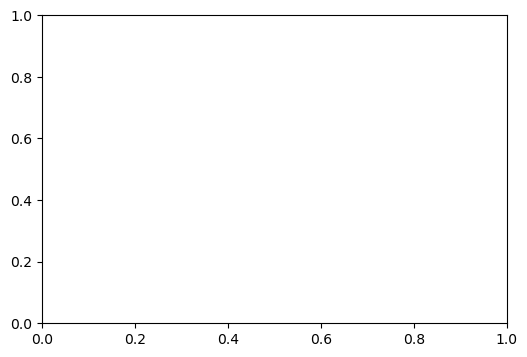

In [9]:
###### size_title = 25
size_ticklabels = 20
size_axeslabels = 40
box_lw = 10

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plot0 = ax.tripcolor(x[:,0], x[:,1], thetaset.grfs_ngo[i](x), cmap='hot')
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
fig.colorbar(plot0, ax=ax)

plt.setp(ax.spines.values(), lw=box_lw, color='black', alpha=1);

# plt.savefig("theta.svg", bbox_inches='tight', transparent=True)


fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plot0 = ax.tripcolor(x[:,0], x[:,1], fset.grfs_ngo[i](x), cmap='hot')
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
fig.colorbar(plot0, ax=ax)

plt.setp(ax.spines.values(), lw=box_lw, color='black', alpha=1);

# plt.savefig("f.svg", bbox_inches='tight', transparent=True)


fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

vmin = min(np.amin(etabset.grfs_ngo[i](x)),np.amin(etatset.grfs_ngo[i](x)))
vmax = max(np.amax(etabset.grfs_ngo[i](x)),np.amax(etatset.grfs_ngo[i](x)))
fig = ax.scatter(x[x[:,1]==0,0], x[x[:,1]==0,1], c=etabset.grfs_ngo[i](x)[x[:,1]==0], label=r'$\eta_\mathrm{bottom}(x)$', s=1000, cmap='hot', vmin=vmin, vmax=vmax)
fig = ax.scatter(x[x[:,1]==1,0], x[x[:,1]==1,1], c=etatset.grfs_ngo[i](x)[x[:,1]==1], label=r'$\eta_\mathrm{top}(x)$', s=1000, cmap='hot', vmin=vmin, vmax=vmax)
# ax.set_title(r"$\eta(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
# ax.legend(fontsize=20)
ax.set_box_aspect(1)
plt.colorbar(fig)
# ax.grid()

plt.setp(ax.spines.values(), lw=box_lw, color='black', alpha=1)

# plt.savefig("eta.svg", bbox_inches='tight', transparent=True)


fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plot1 = ax.tripcolor(x[:,0], x[:,1], u_array[i], cmap='hot')
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
fig.colorbar(plot1, ax=ax)

plt.setp(ax.spines.values(), lw=box_lw, color='black', alpha=1);

# plt.savefig("u.svg", bbox_inches='tight', transparent=True)


fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plot2 = ax.tripcolor(x[:,0], x[:,1], u_hat, cmap='hot', vmin=np.amin(u_array[i]), vmax=np.amax(u_array[i]))
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
fig.colorbar(plot1, ax=ax)

plt.setp(ax.spines.values(), lw=box_lw, color='black', alpha=1);

# plt.savefig("u_hat_DeepONet.svg", bbox_inches='tight', transparent=True)

In [10]:
size_title = 25
size_ticklabels = 10
size_axeslabels = 40

mus = model.Trunk_trial.mus.detach().numpy()
sigmas = torch.exp(model.Trunk_trial.log_sigmas).detach().numpy()

# mus = model.mus[0].detach().numpy()
# sigmas = torch.exp(model.log_sigmas[0]).detach().numpy()

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

for i in range(72):
    ax.scatter(mus[i,0], mus[i,1], s=50, alpha=1, color='C0', label='NGO')
    ax.scatter(mus[i,0], mus[i,1], s=10000*sigmas[i], alpha=0.2, color='C0')
# ax.set_title(r"$\hat{\Theta}_j=\theta(\mathbf{x}_j)$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_aspect('equal')
# ax.set_xlim(-0.5,1.5)
# ax.set_ylim(-0.5,1.5)
# ax.set_xlim(0,1)
# ax.set_ylim(0,1)
ax.grid()
# ax.legend(fontsize=12)

# plt.savefig("phis_boundedcenters_normbasis.svg", bbox_inches='tight')#, transparent=True)

NameError: name 'model' is not defined

In [11]:
x = torch.linspace(0,1,100)
y = torch.zeros(100)
x = torch.vstack([x,y]).T
phi = model.Trunk(x[:None,None,:]).squeeze()

NameError: name 'model' is not defined

In [12]:
D = model.NLBranch.forward(torch.ones((1,12,12), dtype=model.dtype)).squeeze()

NameError: name 'model' is not defined

In [13]:
plt.imshow(D.detach().numpy())
plt.colorbar()

NameError: name 'D' is not defined

In [14]:
G = torch.einsum('mi,ij,nj->mn', phi, D, phi).detach().numpy()
plt.imshow(G)
plt.colorbar()

NameError: name 'phi' is not defined

### Test score VarMiON

In [3]:
#Test dataset
N_samples = 1000
Theta_test = torch.tensor(np.load('../../../trainingdata/grf/fixedl_positivef/test/Theta.npy'))[:N_samples]
F_test = torch.tensor(np.load('../../../trainingdata/grf/fixedl_positivef/test/F.npy'))[:N_samples]
N_test = torch.tensor(np.load('../../../trainingdata/grf/fixedl_positivef/test/N.npy'))[:N_samples]
x_test = torch.tensor(np.load('../../../trainingdata/grf/fixedl_positivef/test/x.npy'))[:N_samples]
u_test = torch.tensor(np.load('../../../trainingdata/grf/fixedl_positivef/test/u.npy'))[:N_samples]

In [4]:
u_test.shape

torch.Size([1000, 268])

In [5]:
from VarMiON import VarMiON
from RegularNN import RegularNN

model = RegularNN
logdir = '../../../nnlogs'
sublogdir = 'grf'
map_location = 'cpu'
RegularNN = loadmodelfromlabel(model=RegularNN, label='RegularNN', logdir=logdir, sublogdir=sublogdir, map_location=map_location)

model = VarMiON
logdir = '../../../nnlogs'
sublogdir = 'grf3'
map_location = 'cpu'

# noLBbias = loadmodelfromlabel(model=model, label='noLBbias', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
# noNLBoutputactivation = loadmodelfromlabel(model=model, label='noNLBoutputactivation', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
# PosDefSymD = loadmodelfromlabel(model=model, label='SymPosDefD', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
# scale_invariant = loadmodelfromlabel(model=model, label='scale_invariant', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
# norm_basis = loadmodelfromlabel(model=model, label='norm_basis', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
# oneovertheta = loadmodelfromlabel(model=model, label='1overtheta', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
tanhshrink = loadmodelfromlabel(model=model, label='tanhshrink', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
# boundedcenters = loadmodelfromlabel(model=model, label='boundedcenters', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
# symgroupavg = loadmodelfromlabel(model=model, label='symgroupavg', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
allchanges = loadmodelfromlabel(model=model, label='allchanges_new', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
# VarMiON = loadmodelfromlabel(model=model, label='VarMiON', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
# NOMAD_dot = loadmodelfromlabel(model=model, label='NOMAD_dot', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
# NOMAD_allchanges = loadmodelfromlabel(model=model, label='NOMAD_allchanges', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
allchanges_new = loadmodelfromlabel(model=VarMiON, label='allchanges_new', logdir=logdir, sublogdir=sublogdir, map_location=map_location)

modeldict = {'Naive NN': RegularNN,
             'VarMiON': VarMiON,
             # 'VarMiON+': allchanges,
             #'No bias': noLBbias,
             #'noNLBoutputactivation': noNLBoutputactivation,
            #'SymPosDefD': PosDefSymD,
             #'Scale invariant': scale_invariant,
             #'Normalized basis': norm_basis,
             #'VarMiON': tanhshrink}#,
             #'1overtheta': oneovertheta,
             #'boundedcenters': boundedcenters,
             # 'NOMAD': NOMAD_dot,
             # 'NOMAD+': NOMAD_allchanges}
             'Extended VarMiON': allchanges_new}

KeyError: 'h'

In [ ]:
size_title = 20
size_ticklabels = 12
size_axeslabels = 30

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']
L2_scaled_avgs = []
i=0
for model in modeldict:
    if modeldict[str(model)].params['hparams']['symgroupavg']==True:
        u_hat = modeldict[str(model)].symgroupavg_forward(Theta_test, F_test, N_test, x_test).detach().numpy()
    else:
        u_hat = modeldict[str(model)].forward(Theta_test, F_test, N_test, x_test).detach().numpy()
    L2 = np.average(np.sqrt((u_hat - u_test.detach().numpy())**2), axis=-1)
    L2_scaled = L2/np.average(np.sqrt((u_test.detach().numpy())**2), axis=-1)
    # APE[np.abs(u_test)<1e-4] = np.nan
    # MAPE = np.nanmean(APE, axis=-1)
    L2_scaled_avg = np.average(L2_scaled)
    sigma = np.std(L2_scaled)
    ax.hist(100*L2_scaled, bins=100, density=True, alpha=0.5, linewidth=1, color=colors[i], histtype='bar')
    ax.axvline(100*L2_scaled_avg, 0, 1, linewidth=3, color=colors[i], label=str(np.around(100*L2_scaled_avg, 2))+r'$\pm$'+str(np.around(100*sigma, 2))+'%, '+str(model))
    i+=1
    L2_scaled_avgs.append(L2_scaled_avg)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(0,15)
ax.legend(fontsize=14)
ax.tick_params(axis='both', labelsize=size_ticklabels)
# ax.ticklabel_format(style='sci', scilimits=[-3,3])
# ax.set_xlabel(r'$\langle|(\hat{u} - u^h)/u^h|\rangle$', fontsize=size_axeslabels)
ax.set_xlabel(r'Validation error in %', fontsize=size_axeslabels)
ax.set_ylabel(r'Density', fontsize=size_axeslabels)
ax.grid()
plt.savefig("NaiveNN.svg", bbox_inches='tight')#, transparent=True)

L2_scaled_avgs = np.array(L2_scaled_avgs)
L2_scaled_avg_avg = np.average(L2_scaled_avgs)
std_L2_scaled_avg = np.std(L2_scaled_avgs)
# print(100*L2_scaled_avg_avg)
# print(100*np.amin(L2_scaled_avgs))
# print(100*np.amax(L2_scaled_avgs))
# print(100*std_L2_scaled_avg)

## Test score NGO

In [4]:
from VarMiON import VarMiON
from RegularNN import RegularNN
from NGO import NGO

logdir = '../../../nnlogs'
map_location = 'cpu'

# sublogdir = 'DeepONet'
# deeponet = loadmodelfromlabel(model=NGO, label='DeepONet', logdir=logdir, sublogdir=sublogdir, map_location=map_location)

sublogdir = 'test'
#DeepONet = loadmodelfromlabel(model=NGO, label='DeepONet', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
#VarMiON = loadmodelfromlabel(model=NGO, label='VarMiON', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
NGO_GL = loadmodelfromlabel(model=NGO, label='newBSplines', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
#NGO_12x12 = loadmodelfromlabel(model=NGO, label='NGO_12x12', logdir=logdir, sublogdir=sublogdir, map_location=map_location)
#NGO_100x100 = loadmodelfromlabel(model=NGO, label='NGO_100x100', logdir=logdir, sublogdir=sublogdir, map_location=map_location)

modeldict = {#'DeepONet': DeepONet,
             #'VarMiON, uniform 12x12': VarMiON,
             #'NGO, uniform 12x12': NGO_12x12,
             #'NGO, uniform 100x100': NGO_100x100,
             'NGO, GL 100x100': NGO_GL,
             'FEM': NGO_GL}

In [5]:
# idx = np.linspace(0,4095, 4096)
# ridx = np.random.choice(idx, 268, replace=False)

In [6]:
#Test dataset
N_samples = 1000
theta_test = load_function_list('theta', '../../../trainingdata/VarMiONpaperdata/test')[:N_samples]
f_test = load_function_list('f', '../../../trainingdata/VarMiONpaperdata/test')[:N_samples]
etab_test = load_function_list('etab', '../../../trainingdata/VarMiONpaperdata/test')[:N_samples]
etat_test = load_function_list('etat', '../../../trainingdata/VarMiONpaperdata/test')[:N_samples]
x_test = np.load('../../../trainingdata/VarMiONpaperdata/test/x.npy')[:N_samples]
u_test = np.load('../../../trainingdata/VarMiONpaperdata/test/u.npy')[:N_samples]

NGO, GL 100x100


/data/storage8/prins/prins/phd/gitlab/ngo-pde-gk/analysisnotebooks/../ml/BSplines.py:88: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "grad" failed type inference due to: non-precise type pyobject
During: typing of argument at /data/storage8/prins/prins/phd/gitlab/ngo-pde-gk/analysisnotebooks/../ml/BSplines.py (100)

File "../ml/BSplines.py", line 100:
    def plot_1d_bspline_basis(self):
        <source elided>

        plt.figure(figsize=(8, 6))
        ^

  def plot_1d_bspline_basis(self):
/data/storage8/prins/prins/phd/gitlab/ngo-pde-gk/analysisnotebooks/../ml/BSplines.py:88: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "grad" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "../ml/BSplines.py", line 105:
    def plot_1d_bspline_basis(self):
        <source elided>
        plt.title(f'1D B-spline Basis Function

FEM


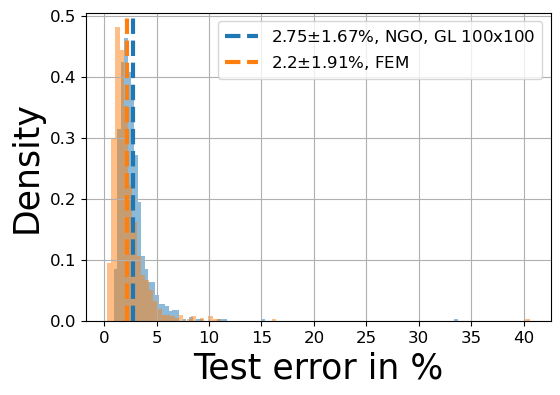

In [8]:
size_title = 20
size_ticklabels = 12
size_axeslabels = 25

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']
L2_scaled_avgs = []
j=0
for model in modeldict:
    print(str(model))
    if str(model)=='FEM':
        modeltype = modeldict[str(model)].hparams['modeltype']
        modeldict[str(model)].hparams['modeltype'] = 'FEM'
        u_hat = modeldict[str(model)].simforward(theta_test, f_test, etab_test, etat_test, x_test)
        modeldict[str(model)].hparams['modeltype'] = modeltype
    else:
        u_hat = modeldict[str(model)].simforward(theta_test, f_test, etab_test, etat_test, x_test)
    L2 = torch.norm(torch.tensor(u_hat) - torch.tensor(u_test), p=2, dim=-1)
    norm = torch.norm(torch.tensor(u_test), p=2, dim=-1)
    L2_scaled = (L2/norm)
    L2_scaled = L2_scaled.detach().numpy()
    # APE[np.abs(u_test)<1e-4] = np.nan
    # MAPE = np.nanmean(APE, axis=-1)
    L2_scaled_avg = np.average(L2_scaled)
    sigma = np.std(L2_scaled)
    ax.hist(100*L2_scaled, bins=100, density=True, alpha=0.5, linewidth=1, color=colors[j], histtype='bar')
    ax.axvline(100*L2_scaled_avg, 0, 1, linewidth=3, linestyle='--', color=colors[j], label=str(np.around(100*L2_scaled_avg, 2))+r'$\pm$'+str(np.around(100*sigma, 2))+'%, '+str(model))
    j+=1
    L2_scaled_avgs.append(L2_scaled_avg)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(0,10)
ax.legend(fontsize=12)
ax.tick_params(axis='both', labelsize=size_ticklabels)
# ax.ticklabel_format(style='sci', scilimits=[-3,3])
# ax.set_xlabel(r'$\langle|(\hat{u} - u^h)/u^h|\rangle$', fontsize=size_axeslabels)
ax.set_xlabel(r'Test error in %', fontsize=size_axeslabels)
ax.set_ylabel(r'Density', fontsize=size_axeslabels)
ax.grid()
# plt.savefig("DeepONetvsNGO.svg", bbox_inches='tight')

L2_scaled_avgs = np.array(L2_scaled_avgs)
L2_scaled_avg_avg = np.average(L2_scaled_avgs)
std_L2_scaled_avg = np.std(L2_scaled_avgs)
# print(100*L2_scaled_avg_avg)
# print(100*np.amin(L2_scaled_avgs))
# print(100*np.amax(L2_scaled_avgs))
# print(100*std_L2_scaled_avg)

KeyboardInterrupt: 

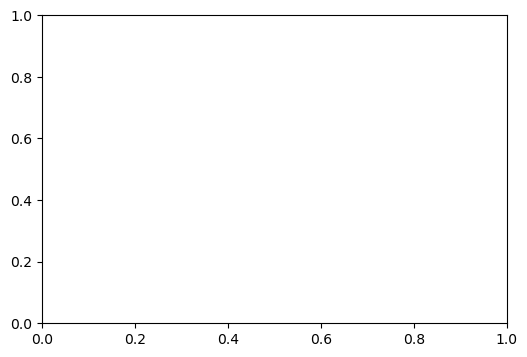

In [28]:
size_title = 20
size_ticklabels = 12
size_axeslabels = 25

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

colors = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']
L2_scaled_avgs = []
j=0
for model in modeldict:
    print(str(model))
    if str(model)=='FEM':
        modeltype = modeldict[str(model)].hparams['modeltype']
        modeldict[str(model)].hparams['modeltype'] = 'FEM'
        u_hat = modeldict[str(model)].simforward(theta_test, f_test, etab_test, etat_test, x_test)
        modeldict[str(model)].hparams['modeltype'] = modeltype
    else:
        u_hat = modeldict[str(model)].simforward(theta_test, f_test, etab_test, etat_test, x_test)
    L2 = torch.norm(torch.tensor(u_hat) - torch.tensor(u_test), p=2, dim=-1)
    norm = torch.norm(torch.tensor(u_test), p=2, dim=-1)
    L2_scaled = (L2/norm)
    L2_scaled = L2_scaled.detach().numpy()
    # APE[np.abs(u_test)<1e-4] = np.nan
    # MAPE = np.nanmean(APE, axis=-1)
    L2_scaled_avg = np.average(L2_scaled)
    sigma = np.std(L2_scaled)
    ax.hist(100*L2_scaled, bins=100, density=True, alpha=0.5, linewidth=1, color=colors[j], histtype='bar')
    ax.axvline(100*L2_scaled_avg, 0, 1, linewidth=3, linestyle='--', color=colors[j], label=str(np.around(100*L2_scaled_avg, 2))+r'$\pm$'+str(np.around(100*sigma, 2))+'%, '+str(model))
    j+=1
    L2_scaled_avgs.append(L2_scaled_avg)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(0,10)
ax.legend(fontsize=12)
ax.tick_params(axis='both', labelsize=size_ticklabels)
# ax.ticklabel_format(style='sci', scilimits=[-3,3])
# ax.set_xlabel(r'$\langle|(\hat{u} - u^h)/u^h|\rangle$', fontsize=size_axeslabels)
ax.set_xlabel(r'Test error in %', fontsize=size_axeslabels)
ax.set_ylabel(r'Density', fontsize=size_axeslabels)
ax.grid()
# plt.savefig("DeepONetvsNGO.svg", bbox_inches='tight')

L2_scaled_avgs = np.array(L2_scaled_avgs)
L2_scaled_avg_avg = np.average(L2_scaled_avgs)
std_L2_scaled_avg = np.std(L2_scaled_avgs)
# print(100*L2_scaled_avg_avg)
# print(100*np.amin(L2_scaled_avgs))
# print(100*np.amax(L2_scaled_avgs))
# print(100*std_L2_scaled_avg)